In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt  # This is for matrix operations
import arviz as az
import matplotlib.pyplot as plt

# Set some sensible defaults
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [2]:
# --- 1. Define Simulation Parameters ---
N_persons = 200
I_items = 30
K_dims = 3

# --- 2. Generate True Parameters (WITH ANCHORS) ---
true_theta = np.random.normal(0, 1, size=(N_persons, K_dims))
true_d = np.random.normal(0, 2, size=I_items) 
true_g = np.random.lognormal(0, 0.5, size=I_items)

# Item Directions (w) with anchors
true_w = np.zeros((I_items, K_dims))
true_w[0] = [1.0, 0.0, 0.0]  # Anchor 1
true_w[1] = [0.0, 1.0, 0.0]  # Anchor 2
true_w[2] = [0.0, 0.0, 1.0]  # Anchor 3

alpha_sparse = np.array([0.5] * K_dims)
true_w[3:] = np.random.dirichlet(alpha_sparse, size=(I_items - K_dims))

# --- 3. Calculate the Linear Predictor (L) ---
dot_prod = np.dot(true_theta, true_w.T)
L_true = true_d + true_g * dot_prod      

# --- 4. Calculate Probabilities and Simulate Responses (Y) ---
P_true = 1 / (1 + np.exp(-L_true))
Y_data = np.random.binomial(1, P_true)

In [3]:
# --- Define the Anchor Priors (Same as before) ---
alpha_anchor_1 = [10.0, 0.5, 0.5]
alpha_anchor_2 = [0.5, 10.0, 0.5]
alpha_anchor_3 = [0.5, 0.5, 10.0]
alpha_sparse = [0.5, 0.5, 0.5]

alpha_prior_matrix = np.tile(alpha_sparse, (I_items, 1))
alpha_prior_matrix[0] = alpha_anchor_1
alpha_prior_matrix[1] = alpha_anchor_2
alpha_prior_matrix[2] = alpha_anchor_3

# Coordinates
coords = {
    "person": np.arange(N_persons),
    "item": np.arange(I_items),
    "dim": np.arange(K_dims)
}

# --- THIS IS THE REVERTED MODEL ---
with pm.Model(coords=coords) as dirichlet_mirt:
    
    Y_obs = pm.Data("Y_obs", Y_data, dims=("person", "item"))

    # --- Person Parameters (CENTERED) ---
    theta = pm.Normal("theta", mu=0, sigma=1, dims=("person", "dim"))

    # --- Item Parameters (CENTERED) ---
    d = pm.Normal("d", mu=0, sigma=5, dims="item")
    g = pm.LogNormal("g", mu=0, sigma=1, dims="item")
    
    # --- Anchored 'w' Prior ---
    w = pm.Dirichlet("w", a=alpha_prior_matrix, dims=("item", "dim"))

    
    # --- Linear Predictor & Likelihood (Same as before) ---
    dot_prod = pt.dot(theta, w.T)
    L = pm.Deterministic("L", d + g * dot_prod)
    Y_hat = pm.Bernoulli("Y_hat", logit_p=L, observed=Y_obs, dims=("person", "item"))

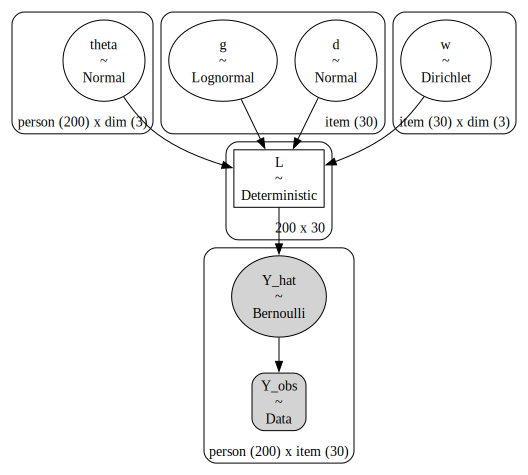

In [4]:
# Let's look at the model structure
pm.model_to_graphviz(dirichlet_mirt)

In [5]:
with dirichlet_mirt:
    # 1. Using the reparameterized model
    # 2. Increasing target_accept to 0.95
    # 3. Using a more standard 2000 draws
    trace = pm.sample(2000, tune=1500, chains=4, cores=4, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, d, g, w]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
# We'll check the main item parameters
var_names = ["d", "g", "w"]
summary = az.summary(trace, var_names=var_names)
print(summary)

# Check for any r_hat > 1.01
if (summary["r_hat"] > 1.01).any():
    print("\nWARNING: Poor convergence detected! Check r_hat values.")
else:
    print("\nSUCCESS: All r_hat values look good. Convergence achieved.")

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
d[0]      1.729  0.518   1.012    2.688      0.024    0.034     635.0   
d[1]     -1.205  0.198  -1.580   -0.843      0.004    0.004    3649.0   
d[2]      0.132  0.186  -0.226    0.464      0.003    0.002    3090.0   
d[3]     -0.020  0.190  -0.394    0.323      0.003    0.002    3169.0   
d[4]     -1.221  0.175  -1.549   -0.902      0.002    0.002    6001.0   
...         ...    ...     ...      ...        ...      ...       ...   
w[28, 1]  0.130  0.117   0.000    0.347      0.003    0.002    1232.0   
w[28, 2]  0.801  0.129   0.581    1.000      0.003    0.001    1898.0   
w[29, 0]  0.325  0.280   0.000    0.842      0.004    0.002    3431.0   
w[29, 1]  0.357  0.289   0.000    0.874      0.004    0.002    3793.0   
w[29, 2]  0.318  0.275   0.000    0.832      0.004    0.002    5633.0   

          ess_tail  r_hat  
d[0]         642.0    1.0  
d[1]        2470.0    1.0  
d[2]        4237.0    1.0  
d[3]       

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_24203/2499437061.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


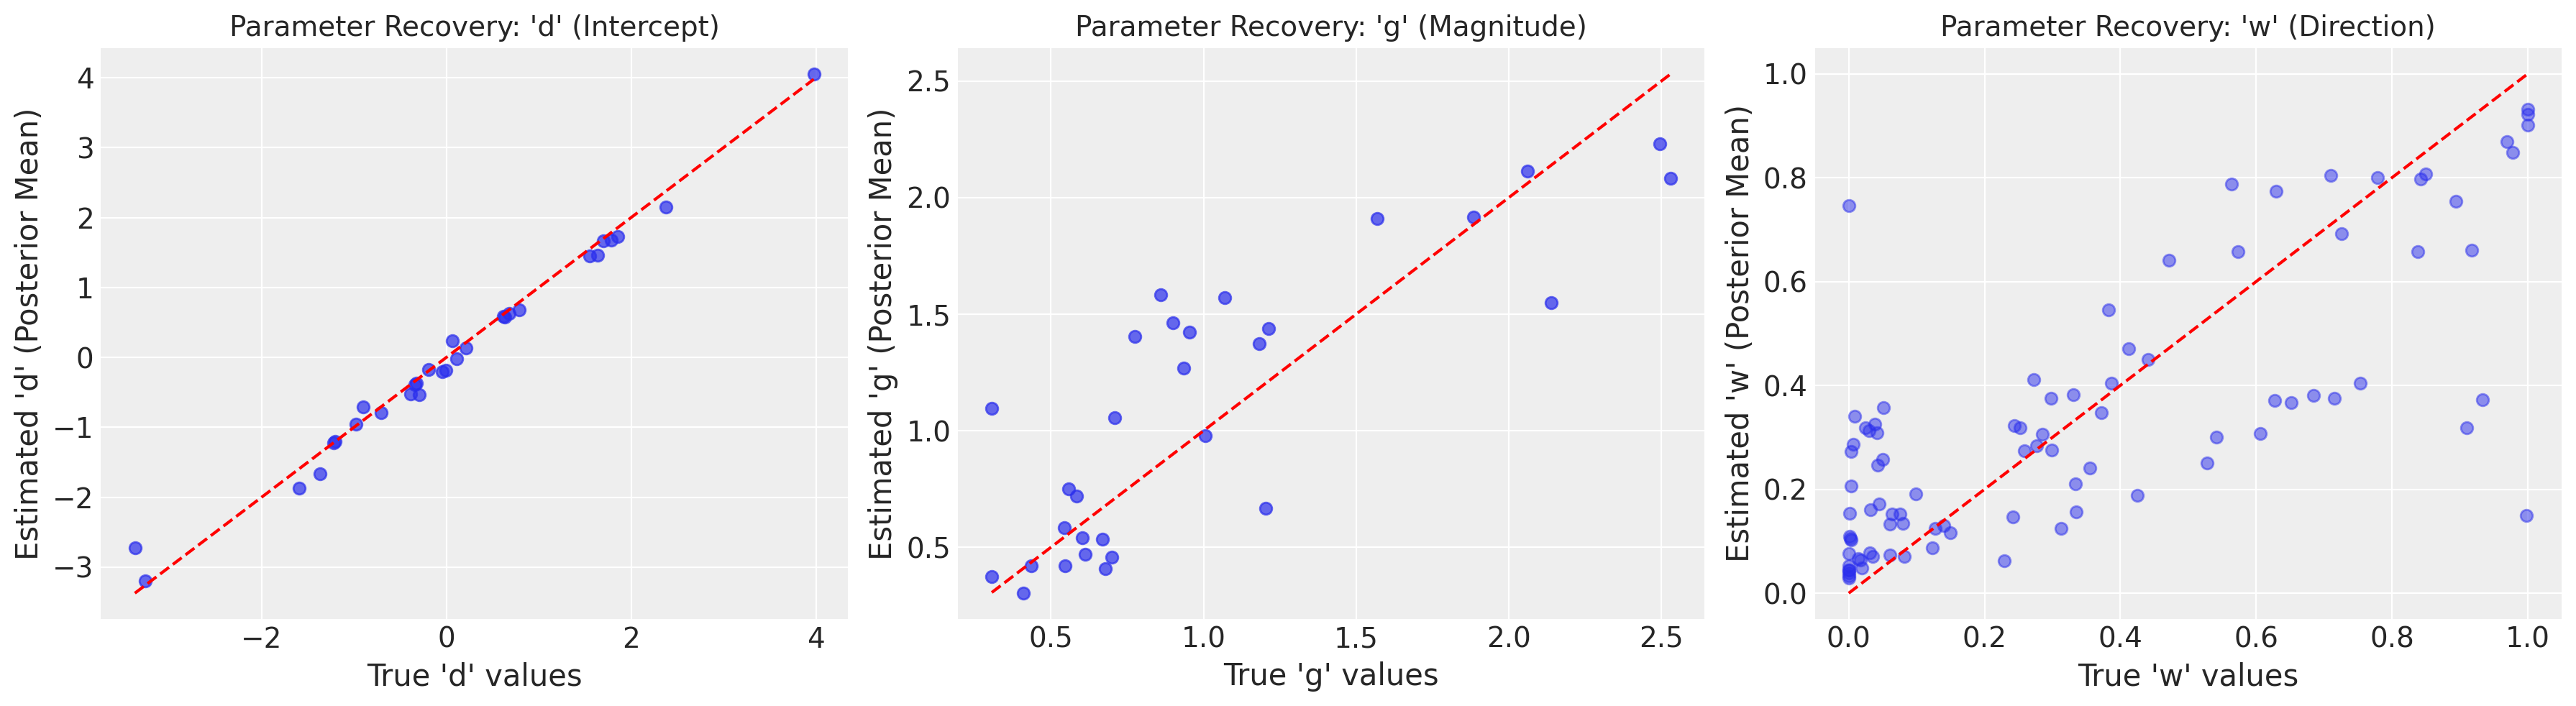

In [7]:
# Extract the posterior means from the summary
est_d = summary.loc[summary.index.str.startswith('d'), 'mean']
est_g = summary.loc[summary.index.str.startswith('g'), 'mean']
est_w = summary.loc[summary.index.str.startswith('w'), 'mean'].values.reshape(I_items, K_dims)

# Create a 3-panel plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 'd' (Intercept) ---
ax[0].scatter(true_d, est_d, alpha=0.7)
ax[0].plot([min(true_d), max(true_d)], [min(true_d), max(true_d)], 'r--')
ax[0].set_title("Parameter Recovery: 'd' (Intercept)", fontsize=14)
ax[0].set_xlabel("True 'd' values")
ax[0].set_ylabel("Estimated 'd' (Posterior Mean)")

# --- Plot 'g' (Magnitude) ---
ax[1].scatter(true_g, est_g, alpha=0.7)
ax[1].plot([min(true_g), max(true_g)], [min(true_g), max(true_g)], 'r--')
ax[1].set_title("Parameter Recovery: 'g' (Magnitude)", fontsize=14)
ax[1].set_xlabel("True 'g' values")
ax[1].set_ylabel("Estimated 'g' (Posterior Mean)")

# --- Plot 'w' (Direction) ---
# This is k-dimensional, so we plot all K*I values flattened
ax[2].scatter(true_w.flatten(), est_w.flatten(), alpha=0.5)
ax[2].plot([0, 1], [0, 1], 'r--')
ax[2].set_title("Parameter Recovery: 'w' (Direction)", fontsize=14)
ax[2].set_xlabel("True 'w' values")
ax[2].set_ylabel("Estimated 'w' (Posterior Mean)")

plt.tight_layout()
plt.show()

Model AUC Score: 0.8658


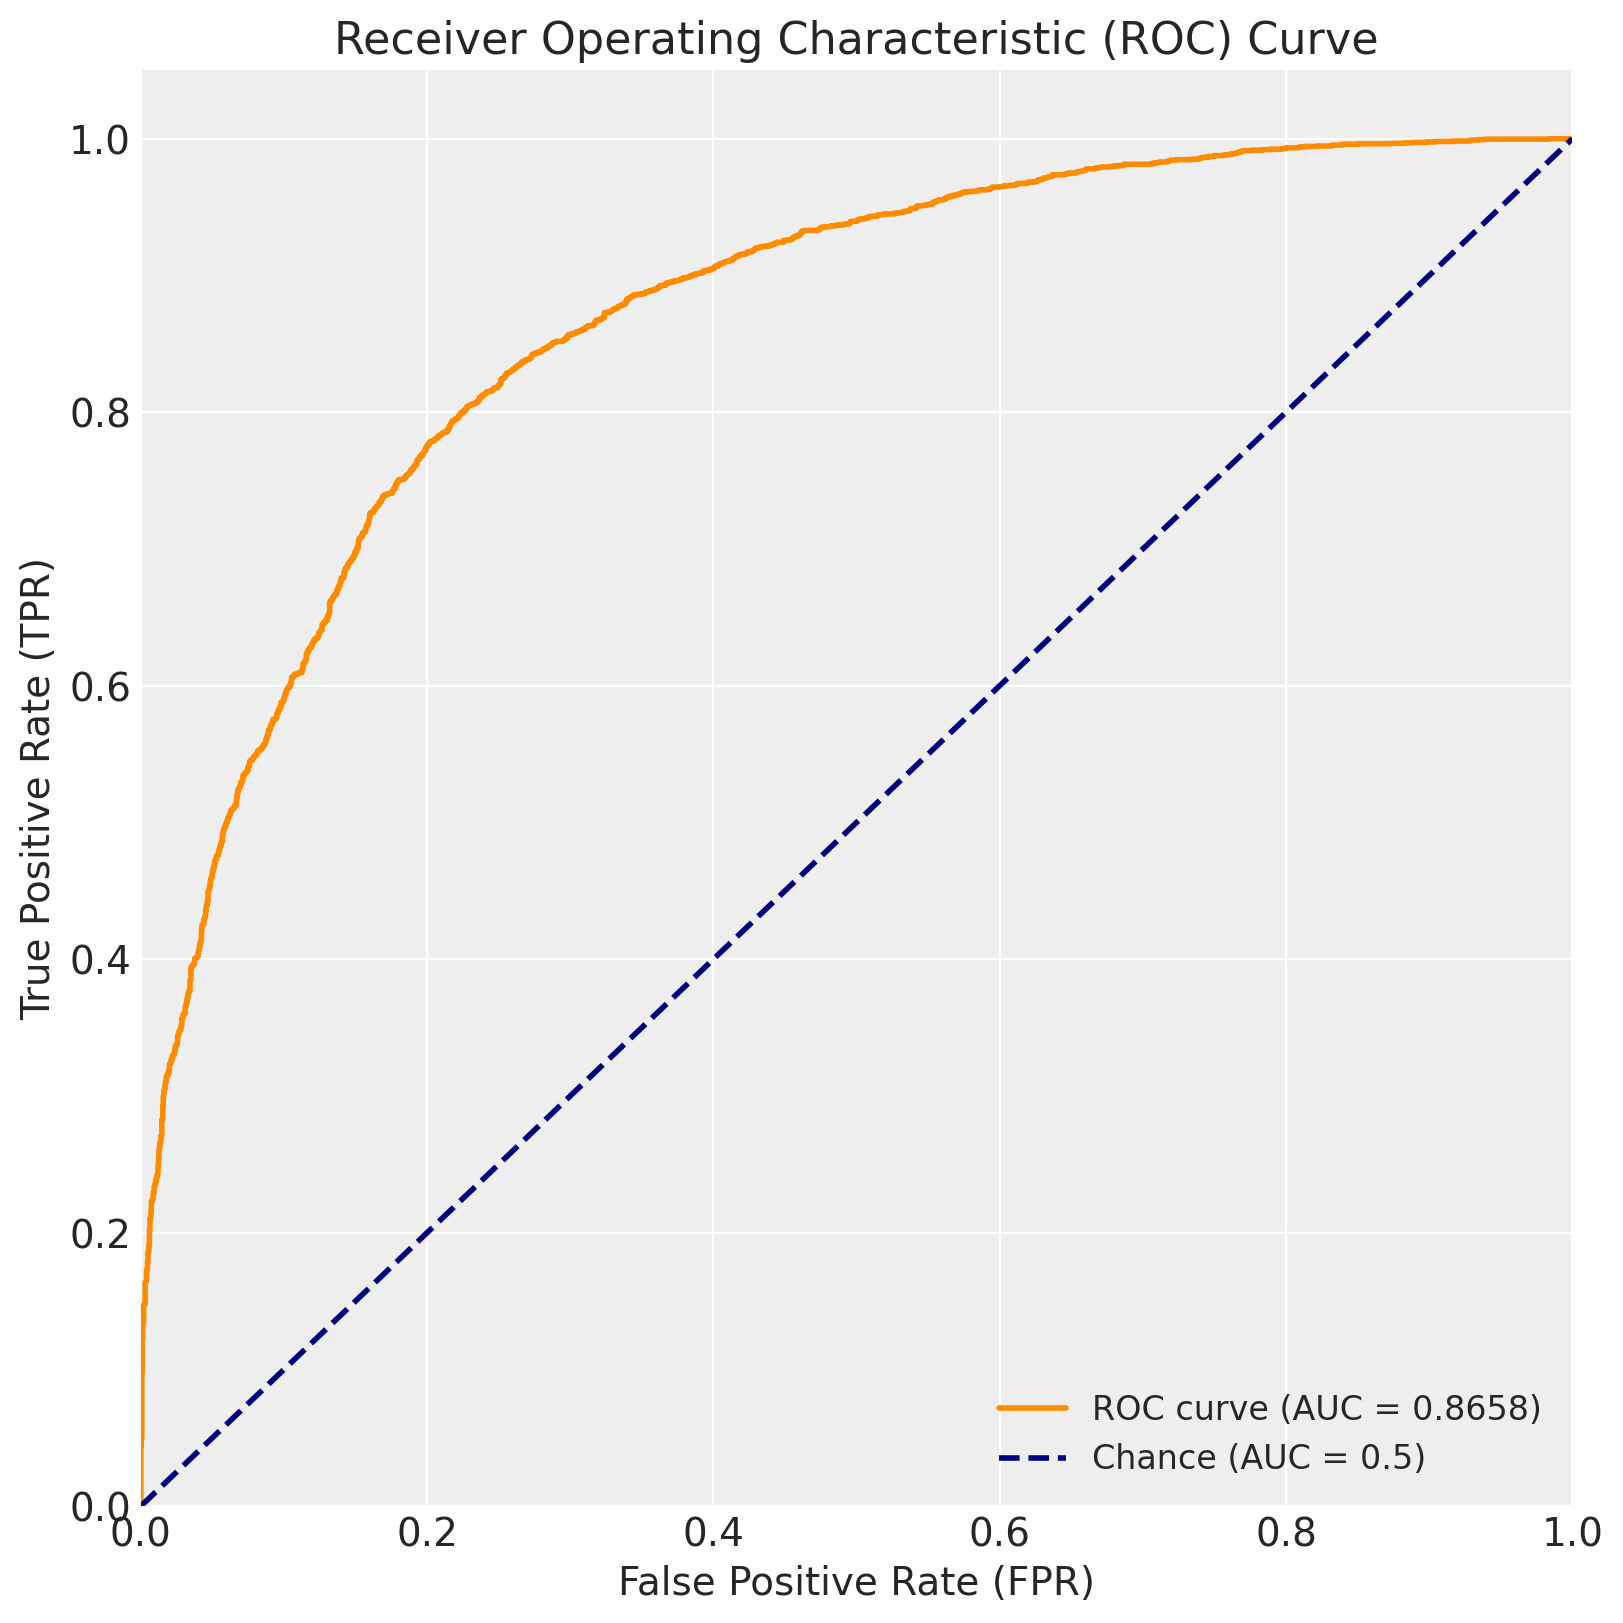

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.special import expit # This is the sigmoid function: 1 / (1 + exp(-x))
import matplotlib.pyplot as plt

# 1. Get the posterior mean of the linear predictor 'L'
# L was defined in our model. The trace object stores all samples.
# Shape will be (N_persons, I_items)
L_mean = trace.posterior["L"].mean(dim=("chain", "draw"))

# 2. Convert the log-odds (L) to probabilities (P) using the sigmoid function
P_predicted = expit(L_mean)

# 3. Flatten the arrays to 1D for sklearn
y_true_flat = Y_data.flatten()
y_pred_flat = P_predicted.values.flatten() # .values converts from xarray to numpy

# 4. Calculate the AUC Score
auc_score = roc_auc_score(y_true_flat, y_pred_flat)
print(f"Model AUC Score: {auc_score:.4f}")

# 5. Calculate the ROC curve points (FPR, TPR)
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)

# 6. Plot the ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()